In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from Plot3D import *

# Camera Models
Example usage of the Camera object 

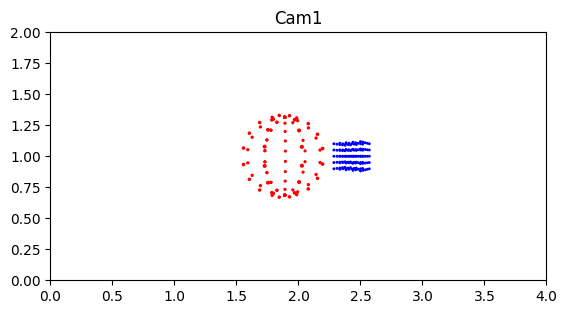

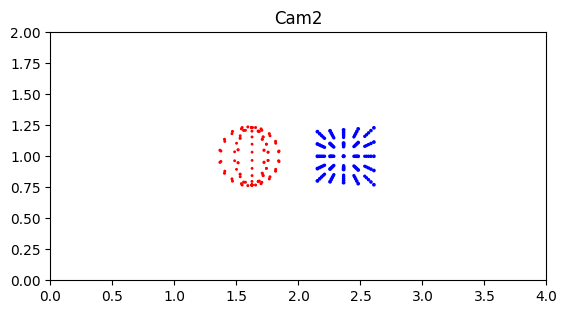

In [2]:
# example data: sphere 
px, py, pz = 4.5, 1, 1
data1 = np.array([[np.cos(theta)*np.sin(phi)+px, np.sin(theta)*np.sin(phi)+py, np.cos(phi)+pz] 
                 for theta in np.linspace(0, 2*np.pi, 10)
                 for phi in np.linspace(0, np.pi, 10)])
# example data: cube
px, py, pz = 4, -2, 1
t_ = np.linspace(-0.5, 0.5, 5)
x_, y_, z_ = t_ + px, t_ + py, t_ + pz
x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
data2 = np.c_[x.ravel(), y.ravel(), z.ravel()]

# create a point cloud object
sample_pts = PointCloud()
sample_pts.add_data([data1, 'red'])
sample_pts.add_data([data2, 'blue'])

# create two cameras
camera1 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1")
camera2 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 1]), "Cam2")

camera1.capture(sample_pts)
camera2.capture(sample_pts)

FIG = Show([camera1, camera2, sample_pts], world=True)

camera1.show_image()
camera2.show_image()

## Camera anatomy 
### Finding the camera center
Camera projection matrix: $P=KR[I|-C]$ <br>
Method 1: Camera center $C$ is in the null space of $P$ such that $PC=0$. <br>
Method 2: Directly derive the solution from the projection matrix. <br>
Method 3: Using the following formula<br>
$x = det([p_2, p_3, p_4]), y = -det([p_1, p_3, p_4]), \\z = det([p_1, p_2, p_4]), t = -det([p_1, p_2, p_3])$



In [3]:
# method 1
def find_center1(P):
    # SVD can generate the basis for the four fundemental spaces 
    homo_c = np.linalg.svd(P)[-1][-1]
    return homo2eucl(homo_c)

# method 2
def find_center2(P):
    M = P[:, :3]
    m = P[:, -1]
    center = -np.linalg.inv(M) @ m
    return center

# method 3
def find_center3(P):
    x = np.linalg.det(np.stack([camera1.P[:, 1], camera1.P[:, 2], camera1.P[:, 3]]))
    y = -np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 2], camera1.P[:, 3]]))
    z = np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 1], camera1.P[:, 3]]))
    t = -np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 1], camera1.P[:, 2]]))
    homo_c = np.array([x, y, z, t])
    return homo2eucl(homo_c)

print("Method 1 :", np.allclose(find_center1(camera1.P), camera1.center))
print("Method 2 :", np.allclose(find_center2(camera1.P), camera1.center))
print("Method 3 :", np.allclose(find_center3(camera1.P), camera1.center))

Method 1 : True
Method 2 : True
Method 3 : True


### Finding the camera orientation and internal parameters

In [4]:
def gram_schmidt(A):
    # Gram-Schmidt only works for full rank matrix
    # if not full rank, use numpy qr decomposition
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print("call numpy qr")
        Q, _ = np.linalg.qr(A)
        return Q
    Q = []
    for i in range(A.shape[1]):
        u = A[:, i]
        for q in Q:
            u = u - (q @ A[:, i]) * q / (q @ q)
        Q.append(u / np.linalg.norm(u))
    return np.array(Q).T

def qr(A):
    Q = gram_schmidt(A)
    R = Q.T @ A 
    return Q, R 

def rq(A):
    Q = gram_schmidt(A.T[:, ::-1])[:, ::-1].T
    R = A @ Q.T
    return R, Q

K, R = rq(camera1.P[:, :-1])
print("Camera calibration matrix (K) :", np.allclose(K, camera1.K))
print("Camera pose (R) :", np.allclose(R, camera1.R))

Camera calibration matrix (K) : True
Camera pose (R) : True


## Computation of the Camera Matrix P
Assume we have a number of point correspondences $\mathbf{X_i} \leftrightarrow \left( {\begin{array}{c} x_i \\ y_i \\ w_i\end{array}} \right)$
$$
\left[ {\begin{array}{ccc}
    0^T & -w_i\mathbf{X}_i^T & y_i\mathbf{X}_i^T \\
    w_i\mathbf{X}_i^T & 0^T & -x_i\mathbf{X}_i^T \\
     & . & \\
     & . & \\
     & . & \\
\end{array}}\right]
\left( {\begin{array}{c} P_1 \\ P_2 \\ P_3 \end{array}}\right) = 0
$$

### Solve $Ap = 0$ subject to  $\lVert p \rVert = 1$ <br>
When the system is over-determined, the problem becomes minimizing $\lVert Ap \rVert$ subject to  $\lVert p \rVert = 1$. <br>
$$
\begin{aligned}
&L(p, \lambda) = p^T A^T A p + \lambda (1 - p^T p) \\
&\frac{\partial L(p, \lambda)}{\partial p} = 2 A^T A p - 2 \lambda p = 0 \\
&\Rightarrow A^T A p = \lambda p \\
&\Rightarrow p = \text{Eigenvector of } A^T A \\
&\Rightarrow p \in \{ v_i| [v_1, v_2, ...]  = V \} \ \text{, where}\ A = U \Sigma V^T 
\end{aligned}
$$
Now we know that $p$ is a singular vector of $A$. Now evaluate the loss function
$$ 
\lVert Ap \rVert = \lVert Av_i \rVert=\sqrt{(Av_i)^T Av_i} = \sqrt{(\sigma_i u_i)^T \sigma_i u_i} = \sqrt{\sigma_i^2} = \sigma_i 
$$
Thus, to minimize this term, we can just choose $p$ to be the singular vector of the smallest singular value of $A$. $\ \ \ \ \square$
<br><br>
Alternative solution can be minimizing $\frac{\lVert Ap\rVert}{\lVert p \rVert}$ directly with no constraint, which leads to the same result. The derivation is omitted here, but can be found in Gil Strang's Linear Algebra textbook.

 

In [5]:
X = eucl2homo(camera1.world_pts)
x = eucl2homo(camera1.image_pts)

def find_P(X, x):
    A = np.zeros((X.shape[0], 2*12))
    for i in range(A.shape[0]):
        A[i, 4:8] = -x[i, 2] * X[i, :]
        A[i, 8:12] = x[i, 1] * X[i, :]
        A[i, 12:16] = x[i, 2] * X[i, :]
        A[i, 20:24] = -x[i, 0] * X[i, :]
    A = A.reshape(int(A.shape[0] * 2), int(A.shape[1] / 2))
    U, sig, Vt = np.linalg.svd(A)
    Pi = Vt[-1, :]

    P = np.stack([Pi[0:4], Pi[4:8], Pi[8:12]])
    P /= P[-1, -1]
    return P

def compareP(P_cam, P_estimate, X, x):
    normalize = lambda P: P/P[-1, -1]
    print("Compare P1 and P2 after rescaled :", np.allclose(normalize(P_cam), normalize(P_estimate)))
    x_estimate = X @ P_estimate.T
    x = homo2eucl(x)
    x_estimate = homo2eucl(x_estimate)
    print("Compare P1 and P2 by point transformation result:", np.allclose(x, x_estimate))

P = find_P(X, x)
compareP(camera1.P, P, X, x)

Compare P1 and P2 after rescaled : True
Compare P1 and P2 by point transformation result: True


## About Pseudoinverse 
Pseudoinverse is part of the solution of $Ax=b$. When the system is over- or underdetermined, $\hat{x}=A^{+} b$, where $A^{+}$ is the pseudoinverse of $A$.

### Case 1: Underdetermined system $Ax=b$ <br>
Since $b \in C(A)$, x has infinite solutions. Thus, the problem becomes minimizing $\lVert x \rVert$ s.t. $Ax=b$.
$$
\begin{aligned}
minimize & \ \lVert x \rVert s.t. Ax=b \\
= minimize & \ \frac{x^T x}{2} \ s.t. \ Ax = b \\
\Rightarrow L(x, \lambda) &= \frac{x^T x}{2} + \lambda^T(b-Ax) \\
\Rightarrow \frac{\partial L(x, \lambda)}{\partial x} &= x - A^T \lambda \Rightarrow x = A^T \lambda \\
\Rightarrow L(\lambda) &= \frac{1}{2} \lambda^T A A^T \lambda + \lambda^T b- \lambda^T A A^T \lambda \\
&= -\frac{1}{2} \lambda^T A A^T \lambda + \lambda^T b \\
\frac{\partial L(\lambda)}{\partial \lambda} &= -A A^T \lambda + b = 0 \\
\Rightarrow b &= A A^T \lambda \\
\Rightarrow \lambda &= (A A^T)^{-1} b  \\
\Rightarrow \hat{x} &= A^T(A A^T)^{-1} b 
\end{aligned}
$$
(Note that $A$ : $m\times n$, m<n. Thus, $A A^T$ is a full rank matrix)

To establish a connection with SVD, let's consider, without loss of generality, matrix $A$ as a $3\times4$ matrix, identical to the camera projection matrix and<br>
$
\Sigma_{3\times3}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  &  \\
    & \sigma_2 &  \\
     &  & \sigma_3 \\
\end{array}}\right], \
\Sigma_{3\times4}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  & & 0 \\
    & \sigma_2 & & 0 \\
     &  & \sigma_3 & 0 \\
\end{array}}\right], \
\Sigma_{4\times3}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  &  \\
    & \sigma_2 &  \\
     &  & \sigma_3 \\
    0 &0 & 0\\
\end{array}}\right], \
\Sigma_{4\times3}^{-1}=
\left[ {\begin{array}{ccc}
    \sigma_1^{-1} &  &  \\
    & \sigma_2^{-1} &  \\
     &  & \sigma_3^{-1} \\
    0 &0 & 0\\
\end{array}}\right], \
U = \left[ u_1 \ u_2 \ u_3\right], \
V = \left[ v_1 \ v_2 \ v_3 \ v_4\right], \
V_{4\times3} = \left[ v_1 \ v_2 \ v_3\right]
$

$$ 
\begin{aligned}
A &= U \Sigma_{3\times 4} V^T \\
A^T &= V \Sigma_{3\times 4}^T U^T \\
A A^T &= U \Sigma_{3\times 4} \Sigma_{3\times 4}^T U^T \\
&= U \Sigma_{3\times 3}^2 U^T \\ \\
A^T(A A^T)^{-1} &= V \Sigma_{3\times 4}^T U^T U (\Sigma_{3\times 3}^2)^{-1} U^T \\
&= V \Sigma_{4\times 3}^{-1} U^T \\
&= V_{4 \times 3} \Sigma_{3 \times 3}^{-1} U^T \\
&= A^{+} \\
\\
\Rightarrow \hat{x} &= A^{+} b  \ \ \ \ \square
\end{aligned}
$$


### Case 2: Overdetermined system $Ax=b$ <br>
When the system is overdetermined, the problem becomes just minimizing $(b - Ax)^T (b - Ax)$ with no constraint.
$$
\begin{aligned}
&\frac{\partial}{\partial x} (b - Ax)^T (b - Ax) = -2A^T(b-Ax)=0 \\
&\Rightarrow A^T A x = A^T b \\
&\Rightarrow x = (A^T A)^{-1} A^T b 
\end{aligned}
$$

In a similar manner,
$$
\begin{aligned}
A^T A &= V \Sigma_{m\times n}^T U^T U \Sigma_{m\times n} V^T \\
&= V \Sigma_{m\times n}^T \Sigma_{m\times n} V^T \\
&= V \mathbf{\Sigma_{n\times n}}^2 V^T \\
\\
(A^T A)^{-1} A^T &= V (\Sigma_{n\times n}^2)^{-1} V^T V \Sigma_{m\times n}^T U^T \\
&= V (\Sigma_{n\times n}^2)^{-1} \Sigma_{m\times n}^T U^T \\
&= V \Sigma_{n\times m}^{-1}  U^T \\
&= V \Sigma_{n\times m}^{-1}  U^T \\
&= V \Sigma_{n\times n}^{-1}  U_{m\times n}^T \\
&= A^{+} \\
\\
\Rightarrow \hat{x} &= A^{+} b  \ \ \ \ \square
\end{aligned}
$$




## The fundemental matrix $F$

The epipolar line is the projection in the second image of the ray from $X$ to the center of the first camera.
$$ 
    l^\prime = e^\prime \times x^\prime = [e^\prime]_\times x^\prime
$$
And the fundemental matrix $F$ is a mapping that maps a 2D image point to its corresponding epipolar line on the other image plane.
$$
    F: x \mapsto l^\prime
$$

### Geometric Derivation
The ray: $X(\lambda) = P^+ x + \lambda C$, where $P P^+ = I$. <br>
$X(\lambda=0)=P^+ x$, $X(\lambda = \infty) = C$. <br>
(Note that $P^+ x \neq X$, $P^+ x$ is a random point on the line $\overleftrightarrow{XC}$)

Then, project $P^+ x$ and C onto the second image plane by multiplying $P^\prime$. <br>
The epipolar line $l^\prime$: 
$$
\begin{aligned}
    l^\prime &= P^\prime C \times P^\prime P^+ x \\
    &= [e^\prime]_\times P^\prime P^+ x \\
    &= Fx \\
    \Rightarrow F &= [e^\prime]_\times P^\prime P^+ \\
\end{aligned}
$$ 
Also,  
$$
\begin{aligned}
    l^\prime &= Fx \\
    \Rightarrow x^{\prime T} l^\prime &= 0 \\
    \Rightarrow x^{\prime T} F x &= 0 
\end{aligned}
$$ 

### Summary of fundemental matrix properties
- Point correspondence <br>
$x^\prime F x = 0$

- Epipolar lines <br>
$l^\prime = Fx$ is the epipolar line corresponding to $x$. <br>
$l = F^T x^\prime$ is the epipolar line corresponding to $x^\prime$.

- Epipoles <br>
$Fe = 0$. <br>
$F^T e^\prime = 0$.

- Computation from camera matrices $P$, $P^\prime$ <br>
$F = [e^\prime]_\times P^\prime P^+$, where $e^\prime=P^\prime C$, with $PC=0$.

In [6]:
def find_F(C, P0, P1):
    C = eucl2homo(C)
    return skew(P1 @ C) @ P1 @ np.linalg.pinv(P0)

# given two 2D points, print the line equation
def line_equation(pt1, pt2):
    m = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    k = (pt1[1] * pt2[0] - pt2[1] * pt1[0]) / (pt2[0] - pt1[0])
    print(f'line equation : {m:.2f}x + {k:.2f} = y')

# point size
size = 5

# create two cameras
cameraA = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1", show_frame=False)
cameraB = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 1]), "Cam2", show_frame=False)

# test point 
X = np.array([5, 2, 1.6])

ptX = PointCloud(size=size)
ptX.add_data([X, 'red']) # will not be plotted 
cameraA.capture(ptX)
cameraB.capture(ptX)

F = find_F(cameraA.center, cameraA.P, cameraB.P)

# =========== x -> l ====================
l = F @ eucl2homo(cameraA.image_pts[0])
# =======================================
    
epiline = CameraLine(l, cameraB, color='red')
line1 = Segment(cameraA.center, cameraB.center)
line2 = Segment(cameraA.center, X, 'red')
line3 = Segment(cameraB.center, X)

# epipole and projected point on second image plane 
epipole1 = homo2eucl(cameraA.P @ eucl2homo(cameraB.center))
epipole2 = homo2eucl(cameraB.P @ eucl2homo(cameraA.center))
Xproj1 = homo2eucl(cameraA.P @ eucl2homo(X))
Xproj2 = homo2eucl(cameraB.P @ eucl2homo(X))
pt_epipole1 = CameraPoint(epipole1, cameraA, size=size)
pt_epipole2 = CameraPoint(epipole2, cameraB, size=size)
pt_Xproj1 = CameraPoint(Xproj1, cameraA, size=size)
pt_Xproj2 = CameraPoint(Xproj2, cameraB, size=size)

# verify fundemental matrix properties 

print("Verify fundemental matrix properties")
print("-"*40)
print("point correspondance :", np.allclose(eucl2homo(cameraB.image_pts[0])[None, :] @ F @ eucl2homo(cameraA.image_pts[0]), 0))
print("l\'=Fx :", "demonstrate using the graph.")
print("Fe = 0 and F^T e\' = 0 :", np.allclose(F @ eucl2homo(epipole1), 0), ",", np.allclose(F.T @ eucl2homo(epipole2), 0))
print("-"*40)

# add name tags
text = Text([pt_epipole1.data, pt_epipole2.data, pt_Xproj1.data, pt_Xproj2.data, X, 2*pt_Xproj2.data-pt_epipole2.data], 
            ['e', 'e\'', 'x', 'x\'', 'X', 'l\''])

FIG = Show([cameraA, cameraB, ptX, epiline, line1, line2, line3, pt_epipole1, pt_epipole2, pt_Xproj1, pt_Xproj2, text], world=True)

Verify fundemental matrix properties
----------------------------------------
point correspondance : True
l'=Fx : demonstrate using the graph.
Fe = 0 and F^T e' = 0 : True , True
----------------------------------------


### The essential matrix $E$
**Derivation** <br>
Consider a pair of cameras: $P = [I|0]$ and $P^\prime = [R | t]$. <br>
The fundemental matrix of this pair is the essential matrix. 
$$
\begin{aligned}
    PC &= 0 \Rightarrow C = \left[ {\begin{array}{c} 0 \\ 0 \\ 0 \\ 1 \\ \end{array}}\right] \\
    e^\prime &= P^\prime C = t \\
    P^+ &= \left[\begin{array}{c} I \\ \hline 0 \end{array}\right] \\ 
    E &= [e^\prime]_\times P^\prime P^+ = [t]_\times R = R [R^T t]_\times
    \\ \\ 
    \hat{x}^{\prime T} E \hat{x} &= 0 \ \text{, where } \hat{x} \text{ is in the camera coordinate frame.}
\end{aligned}
$$

**How to find the relative $R$ and $t$ between two cameras if their projection matrices are not in the form shown above?**<br>
Assume camera 1 has $pose1$ and $center1$, camera 2 has $pose2$ and $center2$. ($pose$ is the rotation matrix that transform the world coordinate to camera coordinate, $center$ is the camera center represented in world coordinate frame).
$$
\begin{aligned}
    X_{world} &= Center + Pose X_{cam} \Rightarrow X_{cam} = Pose^T (X_{world} - Center) \\
    X_{world} &= Pose^{(1)} X_{cam}^{(1)} + Center^{(1)} \\
    &= Pose^{(2)} X_{cam}^{(2)} + Center^{(2)} \\
    X_{cam}^{(2)} &= Pose^{(2)T}(X_{world} - Center^{(2)}) \\
    &= Pose^{(2)T}(Pose^{(1)} X_{cam}^{(1)} + Center^{(1)} - Center^{(2)}) \\
    &= Pose^{(2)T}Pose^{(1)} X_{cam}^{(1)} + Pose^{(2)T}(Center^{(1)} - Center^{(2)}) \\
    &= R X_{cam}^{(1)} + t \\
    \Rightarrow R &= Pose^{(2)T}Pose^{(1)}, \ \ t = Pose^{(2)T}(Center^{(1)} - Center^{(2)})
\end{aligned}
$$

We use $X$ and $X^\prime$ to represent $X_{cam}^{(1)}$ and $X_{cam}^{(2)}$ for convenience. <br>
$$
\begin{aligned}
    X^\prime &= R X + t \\
    [t]_\times X^\prime &= [t]_\times R X + [t]_\times t = [t]_\times R X \\
    X^{\prime T} [t]_\times X^\prime &= 0 = X^{\prime T} [t]_\times R X \\
    \Rightarrow X^{\prime T} [t]_\times R X &= X^{\prime T} E X = 0
\end{aligned}
$$

In [7]:
# create two cameras
cameraA = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1")
cameraB = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 2]), "Cam2")

# define observation data 
pt1 = np.array([4, 1, 1])
pts = PointCloud()
pts.add_data([pt1, 'red'])
cameraA.capture(pts)
cameraB.capture(pts)

X = cameraA.camera_pts[0]

R = cameraB.pose.T @ cameraA.pose
t = cameraB.pose.T @ (cameraA.center - cameraB.center)
Xprime = cameraB.camera_pts[0]
print('X\' = RX + t :', np.allclose(R @ X + t, Xprime))
print('T x X\' = T x RX + T x T :', np.allclose(skew(t) @ Xprime, skew(t) @ R @ X))
print('X\'.(T x X\') = X\'.(T x RX) = 0 :', np.logical_and(
    np.allclose(np.dot(Xprime, skew(t) @ Xprime), np.dot(Xprime, skew(t) @ R @ X)), 
    np.allclose(np.dot(Xprime, skew(t) @ R @ X), 0)))

X' = RX + t : True
T x X' = T x RX + T x T : True
X'.(T x X') = X'.(T x RX) = 0 : True


## Computation of $F$
1. Solve $x^{\prime T} F x = 0$ 
$$
    Af = \left[\begin{array}{c}
        x_1^{\prime} x_1 & x_1^{\prime} y_1 & x_1^{\prime} & 
        y_1^{\prime} x_1 & y_1^{\prime} y_1 & y_1^{\prime} & 
        x_1 & y_1 & 1 \\ 
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        x_n^{\prime} x_n & x_n^{\prime} y_n & x_n^{\prime} & 
        y_n^{\prime} x_n & y_n^{\prime} y_n & y_n^{\prime} & 
        x_n & y_n & 1 
    \end{array}\right] f = 0
$$

2. Singularity constraint: F has to be singular 
$$
\begin{aligned}
    &minimize \ \ \lVert Af^\prime \rVert \ \ s.t. \ \ \lVert f^\prime \rVert =1 \\
    &then \\
    &minimize \ \ \lVert F - F^\prime \rVert \ \ s.t. \ \ det(F) = 0 \\ 
    \\ 
    F^\prime &= U \left[{\begin{array}{c} 
        \sigma_1 &          &          \\
                 & \sigma_2 &          \\
                 &          & \sigma_3 
    \end{array}}\right] V^T \\
    \Rightarrow F &= U \left[{\begin{array}{c} 
        \sigma_1 &          &          \\
                 & \sigma_2 &          \\
                 &          & 0 
    \end{array}}\right] V^T \\
\end{aligned}
$$ 


In [8]:
# image point correspondence
x = camera1.image_pts 
xprime = camera2.image_pts

# add tiny noise to avoid perfect point correspondence
x = x + np.random.randn(*x.shape) * 1e-8

print(f"Point correspondence x: {x.shape}, x\': {xprime.shape}")

def build_A(x1, x2):
    assert x1.shape == x2.shape
    x1 = eucl2homo(x1)
    x2 = eucl2homo(x2)
    N = x1.shape[0]
    A = np.zeros((N, 9))
    for i in range(N):
        A[i, :] = np.outer(x1[i], x2[i]).ravel()
    return A

def solve_Ax_equal_0(A):
    return np.linalg.svd(A)[2][-1, :]

def force_singular(Fprime):
    U, S, Vt = np.linalg.svd(Fprime)
    S[-1] = 0
    return U @ np.diag(S) @ Vt

# build matrix "A"
A = build_A(x, xprime)

# find fundemental matrix F
Fprime = solve_Ax_equal_0(A).reshape(3, 3)
F = force_singular(Fprime)

# analysis
print(f"Rank(F\') = {np.linalg.matrix_rank(Fprime)}")
print(f"Rank(F) = {np.linalg.matrix_rank(F)}")
estimation_error = np.mean(np.abs(np.sum(eucl2homo(xprime) * (eucl2homo(x) @ F.T ), axis=1)))
print(f"Estimation error: mean(abs(x\'Fx - 0)) = {estimation_error:.5f}")

# ground truth F
F_groundtruth = find_F(camera1.center, camera1.P, camera2.P)
estimation_error = np.mean(np.abs(np.sum(eucl2homo(xprime) * (eucl2homo(x) @ F_groundtruth.T ), axis=1)))
print(f"Ground truth error: mean(abs(x\'Fx - 0)) = {estimation_error:.5f}")

Point correspondence x: (225, 2), x': (225, 2)
Rank(F') = 3
Rank(F) = 2
Estimation error: mean(abs(x'Fx - 0)) = 0.02842
Ground truth error: mean(abs(x'Fx - 0)) = 0.00000


## Linear Triangulation Method
**Goal**: $\{\mathbf{x_i} \leftrightarrow \mathbf{x_i^\prime}\} \mapsto X_i$

$$
    \mathbf{x} = PX \Rightarrow \mathbf{x} \times (PX) = 0 \\
    \Rightarrow \begin{vmatrix}
        i       & j       & k      \\
        x       & y       & 1      \\
        P_1^T X & P_2^T X & P_3^T X
    \end{vmatrix} = 0 
    \Rightarrow \begin{cases} 
        y P_3^T X - P_2^T X = 0 \\
        x P_3^T X - P_1^T X = 0 \\
        x P_2^T X - y P_1^T X = 0
    \end{cases} 
$$
Similarily, 
$$ 
    \begin{cases} 
        y^\prime P_3^{\prime T} X - P_2^{\prime T} X = 0 \\
        x^\prime P_3^{\prime T} X - P_1^{\prime T} X = 0 \\
        x^\prime P_2^{\prime T} X - y^\prime P_1^{\prime T} X = 0
    \end{cases} \\ 
    \Rightarrow
    \left[{\begin{array}{c}
        x P_3^T - P_1^T \\
        y P_3^T - P_2^T \\
        x^\prime P_3^{\prime T} - P_1^{\prime T} \\
        y^\prime P_3^{\prime T} - P_2^{\prime T}
    \end{array}}\right] \left[{\begin{array}{c}
        X_1 \\
        X_2 \\
        X_3 \\
        1
    \end{array}}\right] = AX = 0
$$

In [9]:
def build_A(x, xprime, P, Pprime):
    # INPUT
    #  x, xprime: (3, ) array instead of (N, 3)
    A = np.zeros((4, 4))
    A[0, :] = x[0] * P[2, :] - P[0, :]
    A[1, :] = x[1] * P[2, :] - P[1, :]
    A[2, :] = xprime[0] * Pprime[2, :] - Pprime[0, :]
    A[3, :] = xprime[1] * Pprime[2, :] - Pprime[1, :]
    return A 

# Linear Triangulation Method
def triangulate(x, xprime, P, Pprime):
    N = x.shape[0] # number of points to reconstruct
    X = np.zeros((N, 3))
    for i in range(N):
        A = build_A(x[i], xprime[i], P, Pprime)
        _X = solve_Ax_equal_0(A)
        _X = homo2eucl(_X)
        X[i, :] = _X
    return X

x = eucl2homo(camera1.image_pts)
xprime = eucl2homo(camera2.image_pts)
P = camera1.P
Pprime = camera2.P

X = triangulate(x, xprime, P, Pprime)
print("triangulation result matches the ground truth :", np.allclose(X, camera1.world_pts))

# plot the reconstructed points 
reconst_pts = PointCloud()
reconst_pts.add_data([X, 'gray'])
FIG = Show([reconst_pts])




triangulation result matches the ground truth : True


In [10]:
# add some noise to image points 
x += np.random.randn(*x.shape) * 0.02
xprime += np.random.randn(*xprime.shape) * 0.02
X = triangulate(x, xprime, P, Pprime)
reconst_pts = PointCloud()
reconst_pts.add_data([X, 'gray'])
print("Image points + WGN")
FIG = Show([reconst_pts, sample_pts])

Image points + WGN


## Retrieving the camera matrices from $F$
**Canonical form of camera matrices:** <br>
We have two cameras, the canonical form of their matrices are $P = [I|0]$ and $P^\prime = [M|m]$. <br>
The fundemental matrix $F = [m]_\times M$.<br>
Derivation:
$$
\begin{aligned}
    P^+ &=  \left[{\begin{array}{c} I \\ \hline 0\end{array}}\right], \ \
    PC = 0 \Rightarrow C = \left[{\begin{array}{c} 0 \\ 0 \\ 0 \\ 1\end{array}}\right] \\
    \Rightarrow e^\prime &= P^\prime C = m \\
    x^\prime &= P^\prime P^+ x = Mx  \\
    \Rightarrow l^\prime &= e^\prime \times x^\prime = [m]_\times M x = F x \\
    \Rightarrow F &= [m]_\times M
\end{aligned}
$$
(Note that $x^\prime$ here is not the matching point of $x$, but just a random point on the epipolar line $l^\prime$.)

**Lemma 9.11.** <br>
Suppose the $F = [a]_\times A = [\tilde{a}]_\times \tilde{A}$, then $\tilde{a}=ka$, $\tilde{A} = k^{-1}(A+av^T)$ for some nonzero constant $k$ and 3-vector $v$. <br>
Proof: 
$$
\begin{aligned}
    a^T F &= \tilde{a}^T F = 0 \\
    Rank(F) &= 2 \Rightarrow Nullity(F) = 1 \Rightarrow \tilde{a} = ka \\
    [a]_\times A &= [\tilde{a}]_\times \tilde{A} = k [a]_\times A \\
    \Rightarrow [a]_\times (k\tilde{A} - A) &= 0 \\
    \Rightarrow k\tilde{A} - A &= a^T v \ \ \ \text{for some v} \\
    \Rightarrow \tilde{A} &= k^{-1}(A + av^T) \ \ \ \ \square
\end{aligned}
$$

To be continued...


### Reference
- R. Hartley, A. Zisserman Multiple View Geometry in Computer Vision 2nd Ed., Cambridge University Press, 2004